In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os, math, time, json, copy, random
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer

try:
    from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
    HAS_ITERSTRAT = True
except Exception:
    HAS_ITERSTRAT = False

from torchvision import transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

for dirname, _, filenames in os.walk('kaggle/input/human-protein-atlas-image-classification'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip -q install iterstrat

In [2]:
# ---------- config ----------
DATA_DIR = Path("/kaggle/input/human-protein-atlas-image-classification")  # change if needed
IMG_DIR  = DATA_DIR / "train"   # folder with *_red/green/blue/yellow.png
CSV_PATH = DATA_DIR / "train.csv"

OUT_DIR = Path("/kaggle/working/hpa_baseline")
OUT_DIR.mkdir(parents=True, exist_ok=True)

NUM_CLASSES = 19
IMG_SIZE = 512            # 512 is a good balance; you can try 384/640 later
BATCH_SIZE = 16
EPOCHS = 5                # start small; bump later
LR = 1e-4
NUM_WORKERS = 2
SEED = 42

def seed_everything(seed=SEED):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True
seed_everything()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
torch.backends.cudnn.benchmark = True

Device: cuda


In [3]:
!nvidia-smi

Sun Oct 19 02:19:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P0             26W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
def binarize_labels(label_str):
    # labels like "16|0" or "14"
    labels = [int(x) for x in str(label_str).replace(" ", "|").replace(",", "|").split("|") if x!='']
    return labels

def macro_auc(y_true, y_pred):
    # y_* are (N, C)
    aucs = []
    for c in range(y_true.shape[1]):
        pos = y_true[:, c].sum()
        if pos == 0 or pos == y_true.shape[0]:
            continue  # skip degenerate
        try:
            aucs.append(roc_auc_score(y_true[:, c], y_pred[:, c]))
        except Exception:
            pass
    return float(np.mean(aucs)) if aucs else float("nan")

def macro_f1(y_true, y_pred, thr=0.5):
    yp = (y_pred >= thr).astype(int)
    return float(f1_score(y_true, yp, average='macro'))


                                     ID    Label
0  00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     16 0
1  000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  7 1 2 0
2  000a9596-bbc4-11e8-b2bc-ac1f6b6435d0        5
3  000c99ba-bba4-11e8-b2b9-ac1f6b6435d0        1
4  001838f8-bbca-11e8-b2bc-ac1f6b6435d0       18


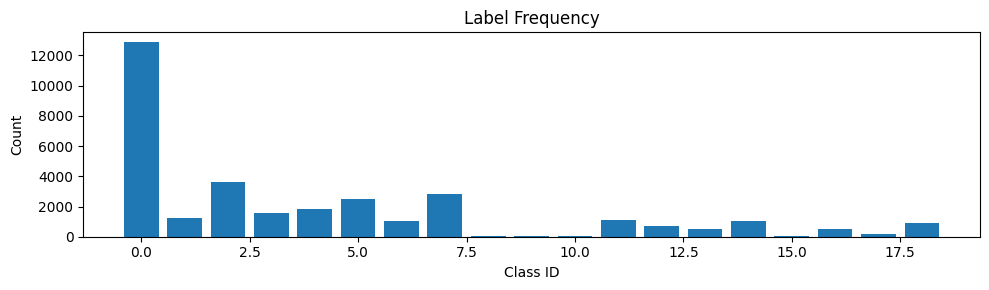

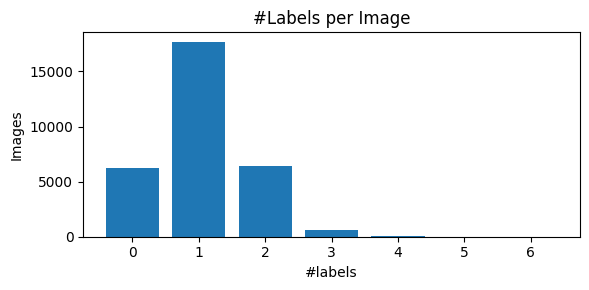

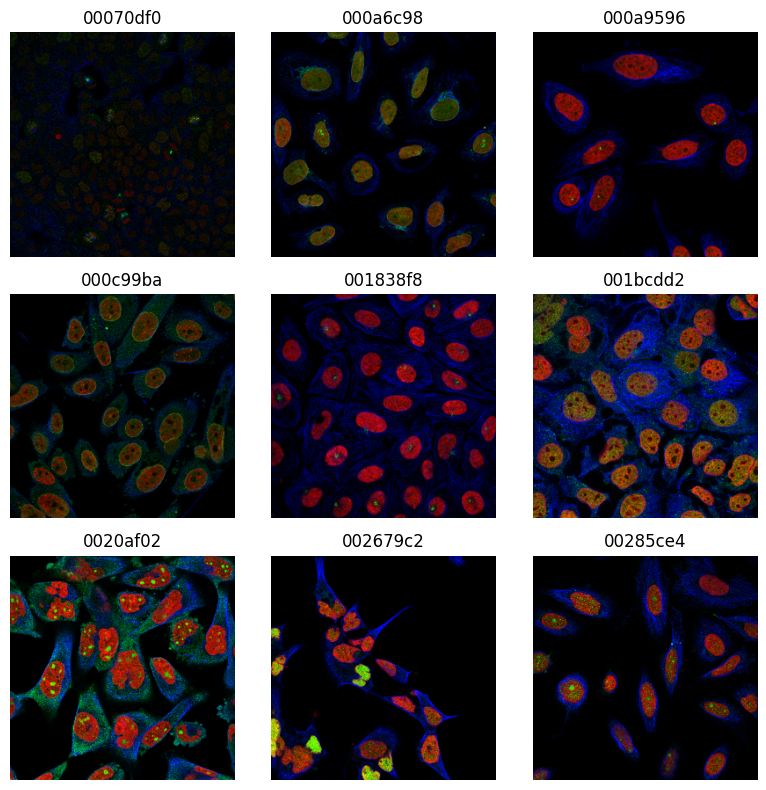

In [5]:
df = pd.read_csv(CSV_PATH)
df.rename(columns={'Id': 'ID', 'Target': 'Label'}, inplace=True)
assert {'ID','Label'}.issubset(df.columns)
print(df.head())

# label frequency
Y = np.zeros((len(df), NUM_CLASSES), dtype=int)
for i, lab in enumerate(df['Label']):
    for l in binarize_labels(lab):
        if 0 <= l < NUM_CLASSES: Y[i, l] = 1

plt.figure(figsize=(10,3))
plt.bar(np.arange(NUM_CLASSES), Y.sum(axis=0))
plt.title("Label Frequency")
plt.xlabel("Class ID"); plt.ylabel("Count"); plt.tight_layout()
plt.savefig(OUT_DIR/"label_frequency.png"); plt.show()

# labels per image
plt.figure(figsize=(6,3))
plt.hist(Y.sum(axis=1), bins=np.arange(0,8)-0.5, rwidth=0.8)
plt.title("#Labels per Image"); plt.xlabel("#labels"); plt.ylabel("Images")
plt.tight_layout(); plt.savefig(OUT_DIR/"labels_per_image.png"); plt.show()

# tiny sample grid (reads *_red/green/blue)
def read_rgby(base_path, image_id, use_yellow=False):
    red   = cv2.imread(str(base_path / f"{image_id}_red.png"),   cv2.IMREAD_UNCHANGED)
    green = cv2.imread(str(base_path / f"{image_id}_green.png"), cv2.IMREAD_UNCHANGED)
    blue  = cv2.imread(str(base_path / f"{image_id}_blue.png"),  cv2.IMREAD_UNCHANGED)
    if red is None or green is None or blue is None:
        return None
    if use_yellow:
        yellow = cv2.imread(str(base_path / f"{image_id}_yellow.png"), cv2.IMREAD_UNCHANGED)
        if yellow is not None:
            red = cv2.addWeighted(red, 0.85, yellow, 0.15, 0)
            green = cv2.addWeighted(green, 0.85, yellow, 0.15, 0)
    rgb = np.stack([red, green, blue], axis=-1)
    return rgb

ids = df['ID'].values[:9]
fig, axes = plt.subplots(3,3, figsize=(8,8))
for ax, img_id in zip(axes.ravel(), ids):
    rgb = read_rgby(IMG_DIR, img_id, use_yellow=False)
    if rgb is not None:
        rgb = cv2.resize(rgb, (256,256))
        ax.imshow(cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)); ax.axis('off'); ax.set_title(img_id[:8])
    else:
        ax.axis('off')
plt.tight_layout(); plt.savefig(OUT_DIR/"sample_grid.png"); plt.show()


In [6]:
mlb = MultiLabelBinarizer(classes=list(range(NUM_CLASSES)))
Y_bin = mlb.fit_transform([binarize_labels(l) for l in df['Label']])
idx = np.arange(len(df))

if HAS_ITERSTRAT:
    from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
    msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=SEED)
    train_idx, temp_idx = next(msss.split(idx, Y_bin))
    msss2 = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.50, random_state=SEED)
    val_rel, test_rel = next(msss2.split(temp_idx, Y_bin[temp_idx]))
    val_idx, test_idx = temp_idx[val_rel], temp_idx[test_rel]
else:
    rng = np.random.RandomState(SEED)
    rng.shuffle(idx)
    n_test = int(0.30*len(idx))
    temp_idx, train_idx = idx[:n_test], idx[n_test:]
    rng.shuffle(temp_idx)
    n_val = int(0.50*len(temp_idx))
    val_idx, test_idx = temp_idx[:n_val], temp_idx[n_val:]

train_df = df.iloc[train_idx].reset_index(drop=True)
val_df   = df.iloc[val_idx].reset_index(drop=True)
test_df  = df.iloc[test_idx].reset_index(drop=True)

print(len(train_df), len(val_df), len(test_df))
train_df.to_csv(OUT_DIR/"train_split.csv", index=False)
val_df.to_csv(OUT_DIR/"val_split.csv", index=False)
test_df.to_csv(OUT_DIR/"test_split.csv", index=False)


21751 4660 4661


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) [19, 20, 21, 22, 23, 24, 25, 26, 27] will be ignored
  warnings.warn(


In [7]:
def apply_clahe_green(rgb, clip_limit=3.0, tile_grid_size=(8,8)):
    r, g, b = cv2.split(rgb)
    clahe = cv2.createCLAHE(clipLimit=float(clip_limit), tileGridSize=tile_grid_size)
    g2 = clahe.apply(g)
    return cv2.merge([r, g2, b])

class HPADataset(Dataset):
    def __init__(self, df, img_dir, img_size=IMG_SIZE, aug=False, use_clahe=False):
        self.df = df.reset_index(drop=True)
        self.img_dir = Path(img_dir)
        self.img_size = img_size
        self.aug = aug
        self.use_clahe = use_clahe

        labels = [binarize_labels(l) for l in self.df['Label']]
        self.mlb = MultiLabelBinarizer(classes=list(range(NUM_CLASSES)))
        self.Y = self.mlb.fit_transform(labels).astype(np.float32)

        if aug:
            self.tf = transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomRotation(90),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.ColorJitter(brightness=0.2, contrast=0.2),
                transforms.ToTensor(),
            ])
        else:
            self.tf = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor(),
            ])

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        image_id = self.df.iloc[idx]['ID']
        rgb = read_rgby(self.img_dir, image_id, use_yellow=False)
        if rgb is None:
            # very rare missing file edge case: return zeros
            x = torch.zeros(3, self.img_size, self.img_size, dtype=torch.float32)
            y = torch.from_numpy(self.Y[idx])
            return x, y
        if self.use_clahe:
            rgb = apply_clahe_green(rgb, clip_limit=3.0, tile_grid_size=(8,8))
        rgb = cv2.resize(rgb, (self.img_size, self.img_size), interpolation=cv2.INTER_AREA)
        rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
        x = self.tf(rgb)   # (3,H,W) in [0,1]
        y = torch.from_numpy(self.Y[idx])
        return x, y


In [8]:
class EffNetB0MultiLabel(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, pretrained=True):
        super().__init__()
        weights = EfficientNet_B0_Weights.IMAGENET1K_V1 if pretrained else None
        self.backbone = efficientnet_b0(weights=weights)
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.3, inplace=True),
            nn.Linear(in_features, num_classes)
        )
    def forward(self, x):
        return self.backbone(x)   # logits


In [9]:
def train_one_epoch(model, loader, optimizer, device, scaler=None):
    model.train()
    loss_fn = nn.BCEWithLogitsLoss()
    total = 0.0
    for x, y in loader:
        x = x.to(device); y = y.to(device)
        optimizer.zero_grad(set_to_none=True)
        if scaler:
            with torch.cuda.amp.autocast():
                logits = model(x)
                loss = loss_fn(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(x)
            loss = loss_fn(logits, y)
            loss.backward()
            optimizer.step()
        total += loss.item() * x.size(0)
    return total / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    loss_fn = nn.BCEWithLogitsLoss()
    ys, ps = [], []
    total = 0.0
    for x, y in loader:
        x = x.to(device); y = y.to(device)
        logits = model(x)
        loss = loss_fn(logits, y)
        total += loss.item() * x.size(0)
        prob = torch.sigmoid(logits)
        ys.append(y.cpu().numpy()); ps.append(prob.cpu().numpy())
    Y = np.concatenate(ys, axis=0)
    P = np.concatenate(ps, axis=0)
    auc = macro_auc(Y, P)
    f1  = macro_f1(Y, P, thr=0.5)
    return total/len(loader.dataset), auc, f1


In [10]:
configs = [
    {"name": "no_aug",      "aug": False, "clahe": False},
    {"name": "domain_aug",  "aug": True,  "clahe": True},
]

for cfg in configs:
    print("\n=== RUN:", cfg["name"], "===\n")
    run_dir = OUT_DIR / cfg["name"]
    run_dir.mkdir(parents=True, exist_ok=True)

    train_set = HPADataset(train_df, IMG_DIR, img_size=IMG_SIZE, aug=cfg["aug"], use_clahe=cfg["clahe"])
    val_set   = HPADataset(val_df,   IMG_DIR, img_size=IMG_SIZE, aug=False,     use_clahe=cfg["clahe"])
    test_set  = HPADataset(test_df,  IMG_DIR, img_size=IMG_SIZE, aug=False,     use_clahe=cfg["clahe"])

    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
    val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

    model = EffNetB0MultiLabel(num_classes=NUM_CLASSES, pretrained=True).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    scaler = torch.cuda.amp.GradScaler() if device.type == "cuda" else None

    best_auc, best_state = -1.0, None
    history = []

    for epoch in range(1, EPOCHS+1):
        t0 = time.time()
        tr_loss = train_one_epoch(model, train_loader, optimizer, device, scaler)
        va_loss, va_auc, va_f1 = evaluate(model, val_loader, device)
        secs = round(time.time()-t0, 2)

        print(f"Epoch {epoch}/{EPOCHS}  train_loss={tr_loss:.4f}  val_loss={va_loss:.4f}  val_AUC={va_auc:.4f}  val_F1={va_f1:.4f}  [{secs}s]")
        history.append({
            "epoch": epoch, "train_loss": tr_loss, "val_loss": va_loss,
            "val_macro_auc": va_auc, "val_macro_f1": va_f1, "seconds": secs
        })
        if not math.isnan(va_auc) and va_auc > best_auc:
            best_auc = va_auc
            best_state = copy.deepcopy(model.state_dict())

    # save & test best
    with open(run_dir/"metrics.json", "w") as f:
        json.dump(history, f, indent=2)

    if best_state is not None:
        torch.save(best_state, run_dir/"best_model.pt")
        model.load_state_dict(best_state)

    te_loss, te_auc, te_f1 = evaluate(model, test_loader, device)
    with open(run_dir/"test_metrics.json", "w") as f:
        json.dump({"test_loss": te_loss, "test_macro_auc": te_auc, "test_macro_f1": te_f1}, f, indent=2)

    print(f"[{cfg['name']}] TEST  loss={te_loss:.4f}  AUC={te_auc:.4f}  F1={te_f1:.4f}")



=== RUN: no_aug ===



Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 107MB/s] 
/tmp/ipykernel_37/1378656121.py:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if device.type == "cuda" else None
/tmp/ipykernel_37/1329633855.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/5  train_loss=0.1364  val_loss=0.0925  val_AUC=0.8852  val_F1=0.3609  [520.61s]


/tmp/ipykernel_37/1329633855.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2/5  train_loss=0.0898  val_loss=0.0810  val_AUC=0.9251  val_F1=0.4301  [354.21s]


/tmp/ipykernel_37/1329633855.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 3/5  train_loss=0.0786  val_loss=0.0764  val_AUC=0.9366  val_F1=0.4826  [349.4s]


/tmp/ipykernel_37/1329633855.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 4/5  train_loss=0.0697  val_loss=0.0746  val_AUC=0.9425  val_F1=0.5052  [350.83s]


/tmp/ipykernel_37/1329633855.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 5/5  train_loss=0.0625  val_loss=0.0742  val_AUC=0.9465  val_F1=0.5422  [352.24s]
[no_aug] TEST  loss=0.0760  AUC=0.9444  F1=0.5789

=== RUN: domain_aug ===



/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) [19, 20, 21, 22, 23, 24, 25, 26, 27] will be ignored
  warnings.warn(
/tmp/ipykernel_37/1378656121.py:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if device.type == "cuda" else None
/tmp/ipykernel_37/1329633855.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/5  train_loss=0.1393  val_loss=0.0971  val_AUC=0.8725  val_F1=0.3445  [413.87s]


/tmp/ipykernel_37/1329633855.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2/5  train_loss=0.0964  val_loss=0.0835  val_AUC=0.9192  val_F1=0.4237  [432.57s]


/tmp/ipykernel_37/1329633855.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 3/5  train_loss=0.0875  val_loss=0.0774  val_AUC=0.9396  val_F1=0.4568  [419.72s]


/tmp/ipykernel_37/1329633855.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 4/5  train_loss=0.0819  val_loss=0.0733  val_AUC=0.9455  val_F1=0.4958  [419.14s]


/tmp/ipykernel_37/1329633855.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 5/5  train_loss=0.0780  val_loss=0.0736  val_AUC=0.9523  val_F1=0.5221  [426.18s]
[domain_aug] TEST  loss=0.0753  AUC=0.9411  F1=0.6057


In [13]:
for name in ["no_aug", "domain_aug"]:
    with open(OUT_DIR/name/"test_metrics.json") as f:
        m = json.load(f)
    print(f"{name:12s}  AUC={m['test_macro_auc']:.4f}  F1={m['test_macro_f1']:.4f}")


no_aug        AUC=0.9444  F1=0.5789
domain_aug    AUC=0.9411  F1=0.6057
